In [55]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)



3670


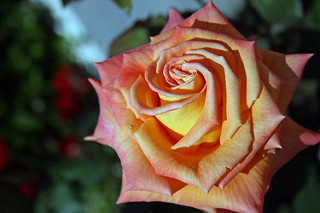

In [56]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[10]))


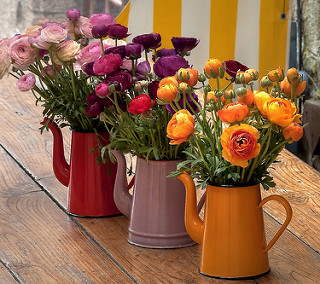

In [57]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[101]))

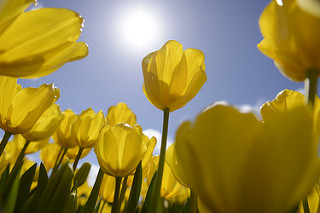

In [58]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[10]))


In [59]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [60]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [61]:
class_names = train_ds.class_names
print(class_names)


['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


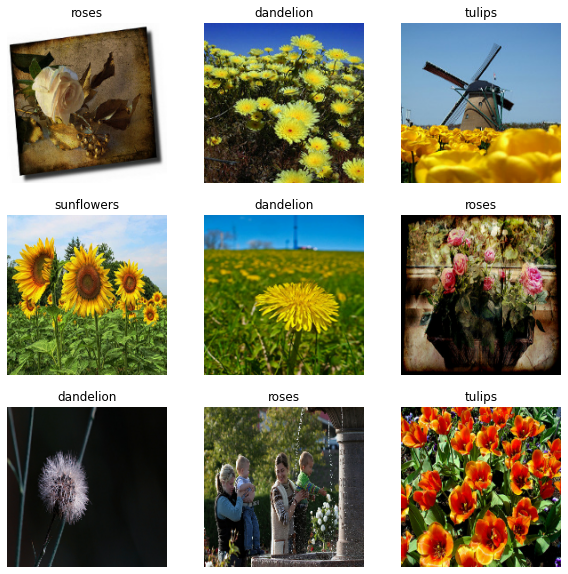

In [62]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()


In [63]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 180, 180, 3)
(32,)


In [64]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [65]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


In [66]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_7 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 22, 22, 64)       

In [67]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10
92/92 [==============================] - 7s 31ms/step - loss: 1.3869 - accuracy: 0.4128 - val_loss: 1.1168 - val_accuracy: 0.5218
Epoch 2/10
92/92 [==============================] - 2s 20ms/step - loss: 1.0045 - accuracy: 0.5995 - val_loss: 0.9876 - val_accuracy: 0.6158
Epoch 3/10
92/92 [==============================] - 2s 20ms/step - loss: 0.8170 - accuracy: 0.6938 - val_loss: 0.8916 - val_accuracy: 0.6485
Epoch 4/10
92/92 [==============================] - 2s 20ms/step - loss: 0.6017 - accuracy: 0.7786 - val_loss: 0.8997 - val_accuracy: 0.6417
Epoch 5/10
92/92 [==============================] - 2s 20ms/step - loss: 0.4188 - accuracy: 0.8392 - val_loss: 1.0870 - val_accuracy: 0.6390
Epoch 6/10
92/92 [==============================] - 2s 20ms/step - loss: 0.2461 - accuracy: 0.9213 - val_loss: 1.2228 - val_accuracy: 0.6144
Epoch 7/10
92/92 [==============================] - 2s 20ms/step - loss: 0.1306 - accuracy: 0.9649 - val_loss: 1.2912 - val_accuracy: 0.6635
Epoch 8/10
92

In [68]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


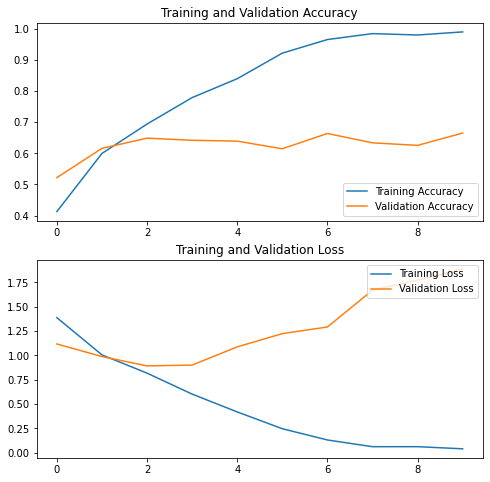

In [69]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


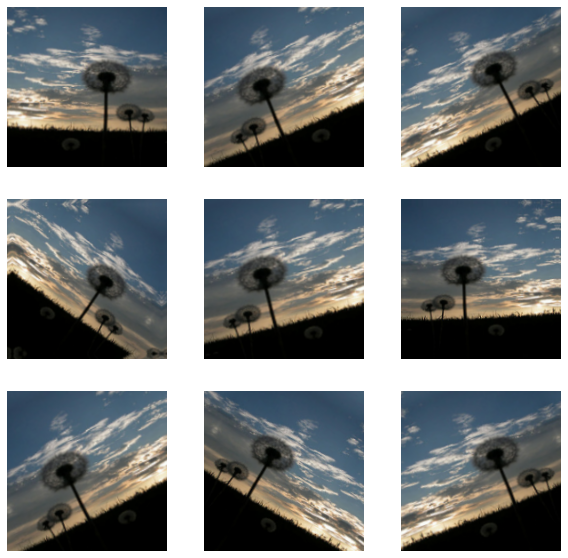

In [70]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")
plt.show()

In [71]:
from tensorflow.keras.models import Sequential

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_7 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_8 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 45, 45, 64)       

In [72]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/20
92/92 [==============================] - 3s 24ms/step - loss: 1.3757 - accuracy: 0.3903 - val_loss: 1.1226 - val_accuracy: 0.5422
Epoch 2/20
92/92 [==============================] - 2s 22ms/step - loss: 1.0514 - accuracy: 0.5760 - val_loss: 1.0554 - val_accuracy: 0.5858
Epoch 3/20
92/92 [==============================] - 2s 22ms/step - loss: 0.9272 - accuracy: 0.6362 - val_loss: 0.9719 - val_accuracy: 0.6226
Epoch 4/20
92/92 [==============================] - 2s 22ms/step - loss: 0.8652 - accuracy: 0.6689 - val_loss: 1.1011 - val_accuracy: 0.6022
Epoch 5/20
92/92 [==============================] - 2s 22ms/step - loss: 0.7991 - accuracy: 0.6938 - val_loss: 0.8454 - val_accuracy: 0.6635
Epoch 6/20
92/92 [==============================] - 2s 22ms/step - loss: 0.7832 - accuracy: 0.7006 - val_loss: 0.8550 - val_accuracy: 0.6635
Epoch 7/20
92/92 [==============================] - 2s 22ms/step - loss: 0.7334 - accuracy: 0.7207 - val_loss: 0.7750 - val_accuracy: 0.6921
Epoch 8/20
92

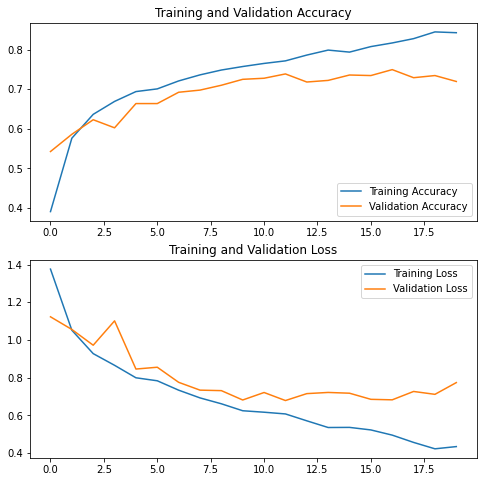

In [73]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [76]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to sunflowers with a 99.95 percent confidence.
